Running A2C_0
Running PPO_0.601209604248657
Running A2C_16598464204208657
Running PPO_16299697404068656
Running A2C_32215053603358658
Running PPO_32226959903718656
Running A2C_64_32388503498657
Running PPO_64_32083203418658


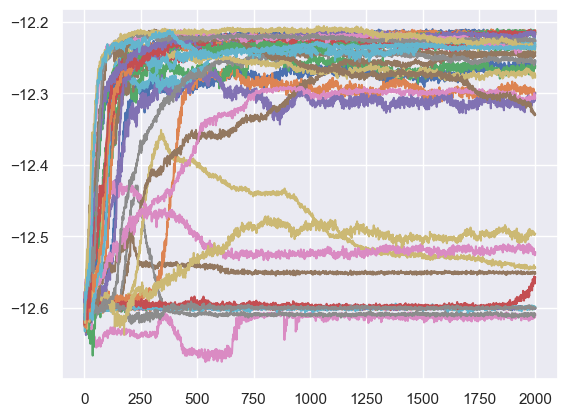

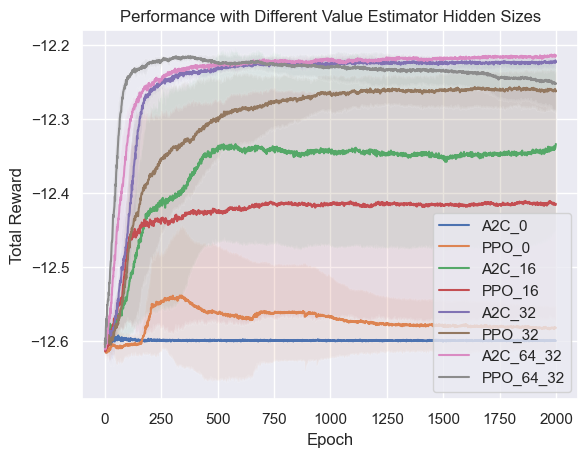

In [1]:
import os
import gym
from environments.energy_management_env import EnergyManagementEnv
from environments.env_registration import register_env
from rl_monitoring_utils.vectorized_env_wrapper import VectorizedEnvWrapper
from policies.categorical_policy import CategoricalPolicy
from learning_utils.value_estimator import ValueEstimator
from agents.a2c import A2C
from agents.ppo import PPO
import numpy as np
import matplotlib.pyplot as plt

# Define environment parameters and register the environment
env_params = {
    'SOC_min': 0.2,
    'SOC_max': 0.8,
    'E': 1000,
    'lambda_val': 0.1,
    'data_path': 'data/Data_input.csv',
    'initial_SOC': 0.5
}
register_env('EnergyManagement-v0', 'environments.env_registration:environment_creator', {'environment_class': EnergyManagementEnv, **env_params})

# Function to run experiments
def run_experiment(env, policy_class, agent_class, value_hidden_sizes, epochs, gamma, T, num_runs):
    totals = []
    for _ in range(num_runs):
        policy = policy_class(env, lr=1e-2, hidden_sizes=[])
        value_estimator = ValueEstimator(env, lr=1e-2, hidden_sizes=value_hidden_sizes)
        agent, total_rewards = agent_class(env, policy, value_estimator, epochs=epochs, gamma=gamma, T=T)
        totals.append(total_rewards)
    return totals

# Configuration for experiments
value_hidden_sizes_configurations = [
    [], [16], [32], [64, 32]
]
num_envs = 8
num_runs = 5
epochs = 2000
gamma = 1
T = 720

results = {}
energy_management = VectorizedEnvWrapper(gym.make("EnergyManagement-v0"), num_envs=num_envs)

# Run experiments for both A2C and PPO with varying hidden sizes in the value estimator
for value_hidden_sizes in value_hidden_sizes_configurations:
    for agent_class, agent_name in [(A2C, 'A2C'), (PPO, 'PPO')]:
        label = f'{agent_name}_{"_".join(map(str, value_hidden_sizes)) if value_hidden_sizes else "0"}'
        print(f"Running {label}")
        results[label] = run_experiment(energy_management, CategoricalPolicy, agent_class, value_hidden_sizes, epochs, gamma, T, num_runs)

# Plot results
fig, ax = plt.subplots()
for label, data in results.items():
    means = np.mean(data, axis=0)
    stddev = np.std(data, axis=0)
    epochs_range = range(len(means))
    ax.plot(epochs_range, means, label=label)
    ax.fill_between(epochs_range, means - stddev, means + stddev, alpha=0.1)
ax.set_title('Performance with Different Value Estimator Hidden Sizes')
ax.set_xlabel('Epoch')
ax.set_ylabel('Total Reward')
ax.legend()
plt.show()
